- 3 types of Ensemble learning techniques:
  - Boosting
  - Bagging
  - Stacking
- Stacking (stacked generalization) with multiple models that could have different types and algorithms. These models are categorized in 2 tiers:
  - base models (level 0 models)
  - meta model (level 1 model)
- The main goal is to build a complex algorithm that leverages the strengths of each individual model to produce more accurate prediction

![stacking](https://miro.medium.com/v2/resize:fit:1050/1*DM1DhgvG3UCEZTF-Ev5Q-A.png)

1. Training the base models (could be any type of ML model that gives the same output format)
2. Capture the output for each model and use it to train the Meta Model (Meta features)
3. The Meta model will be trained on predicted data (original label with new features)
4. Making the final prediction based on unseen data from the prediction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# generate a complex dataset
from sklearn.datasets import make_moons

#to split the data
from sklearn.model_selection import train_test_split

In [14]:
# base models - Random Forest, SVC, Logistic Regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# meta model
from tensorflow.keras import Sequential, layers

#evaluation
from sklearn.metrics import accuracy_score


In [ ]:
#generate the data (complex non-linear relationship with binary classification)

X, y = make_moons(n_samples=2000, noise=.3, random_state=10)

In [7]:
X[:10] # it dfined 2 features

array([[ 0.93592806,  0.41528244],
       [ 1.76927646, -0.21343109],
       [ 0.75962056, -0.58585576],
       [ 1.22519484,  0.41683551],
       [-0.0478664 ,  0.13190213],
       [ 2.04242291,  0.11213626],
       [-0.13763898,  0.92200803],
       [ 0.18773525,  0.80444595],
       [ 0.73381944,  0.12641628],
       [ 0.15668332,  1.34059763]])

Text(0, 0.5, 'Feature 2')

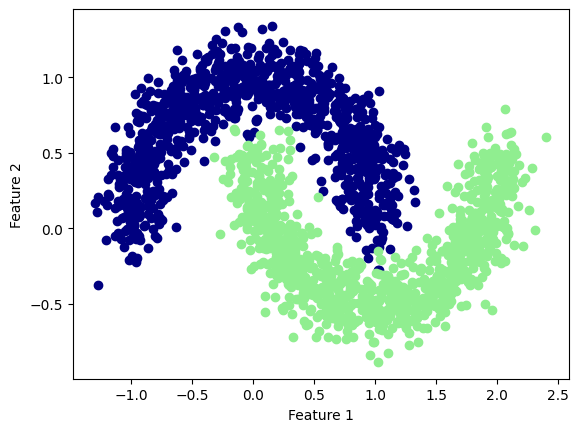

In [8]:
#plot the generated data
#scatter for lable = 0
plt.scatter(x=X[y==0][:,0], #grab data for lable 0 and first feature (x-axis on the plot)
            y=X[y==0][:,1], #grab data for lable 0 and second feature (y-axis on the plot)
            c='navy'
            )

#scatter for lable = 1
plt.scatter(x=X[y==1][:,0], #grab data for lable 0 and first feature (x-axis on the plot)
            y=X[y==1][:,1], #grab data for lable 0 and second feature (y-axis on the plot)
            c='lightgreen'
            )
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

## Split The Data

In [9]:
# split our data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

## Define Base Models

In [10]:
# define my base models

log_reg = LogisticRegression(solver='lbfgs', random_state=10)
rnd_for = RandomForestClassifier(n_estimators=100, random_state=10)
svm_cl = SVC(random_state=10, probability=True) # prob hyperparameter here helps with model stacking compatibility

Note: If you want to stick with one ML library, TF and Keras offer similar algorithms. Example:
- decision forests https://www.tensorflow.org/decision_forests
- logistic regression https://gist.github.com/fchollet/b7507f373a3446097f26840330c1c378
- gradient boosted trees https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel

# Define The Meta Model

In [20]:
# let's build our meta model

# package all NN steps into one function

def my_nn():
  nn_model = Sequential([
      layers.Dense(60, activation='relu', input_shape=[2]),
      layers.Dense(1, activation ='sigmoid') #binary classification output
  ])

  nn_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

  return nn_model

- In order to make sk learn models compatible with TF and Keras, we need to use a wrapper or bridge module
- install `scikeras`
- Note: installing `scikeras` may uninstall tensorflow.keras module, if that happens, restart, reinstall, and restart

In [18]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 32.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


## Integrate All The Components And User A Wrapper

In [21]:
from scikeras.wrappers import KerasClassifier #for regression, import KerasRegressor

keras_nn = KerasClassifier(my_nn, epochs=20)

In [22]:
keras_nn._estimator_type = 'classifier'

There are 2 voting mechanisms:
- 'soft' voting means applying an activation function (argmax) on the sum of predicted probability (recommended with nn)
- 'hard' choosing the majority rule coting

In [23]:
# assemble all the models (base and meta) with a voting mechanism
from sklearn.ensemble import VotingClassifier

voter = VotingClassifier(
                          estimators = [
                              ('lr', log_reg),
                              ('rf', rnd_for),
                              ('svc', svm_cl),
                              ('keras',keras_nn)
                          ],
                          voting='soft',
                          flatten_transform=True #another compatibility parameter

                          )

In [24]:
# deploy the model and train
voter.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5002 - loss: 0.6959
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8534 - loss: 0.5301
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8406 - loss: 0.4223
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8323 - loss: 0.3696
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8601 - loss: 0.3289
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8444 - loss: 0.3251
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8676 - loss: 0.2903
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8802 - loss: 0.2738
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8911 - loss: 0.2624
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8951 - loss: 0.2464
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8872 - loss: 0.2593
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8812 - lo

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=10)),
                             ('rf', RandomForestClassifier(random_state=10)),
                             ('svc', SVC(probability=True, random_state=10)),
                             ('keras',
                              KerasClassifier(epochs=20, model=<function my_nn at 0x7cd234b91510>))],
                 voting='soft')

In [25]:
score_list = []

for model_name in [log_reg, rnd_for, svm_cl, keras_nn, voter]:
  print(f'Starting {model_name}' )
  # fitting the model
  model_name.fit(X_train, y_train)
  # get predicted labels
  y_pred = model_name.predict(X_test)
  #evaluate the labels
  acc_sc = accuracy_score(y_test, y_pred)

  #add accuracy score to the list
  score_list.append(acc_sc)
  print(f'Training and evaluation model {model_name} is complete')

Starting LogisticRegression(random_state=10)
Training and evaluation model LogisticRegression(random_state=10) is complete
Starting RandomForestClassifier(random_state=10)
Training and evaluation model RandomForestClassifier(random_state=10) is complete
Starting SVC(probability=True, random_state=10)
Training and evaluation model SVC(probability=True, random_state=10) is complete
Starting KerasClassifier(
	model=<function my_nn at 0x7cd234b91510>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight=None
)
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6619 - loss: 0.6583
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8090 - loss: 0.5008
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8280 - loss: 0.4005
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8421 - loss: 0.3435
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 - loss: 0.3158
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8612 - loss: 0.3067
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8745 - loss: 0.2850
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8846 - loss: 0.2612
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8636 - loss: 0.2803
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8875 - loss: 0.2474
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8802 - loss: 0.2600
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8790 - loss: 0.2483

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5616 - loss: 0.6845
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7372 - loss: 0.5546
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7963 - loss: 0.4492
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8362 - loss: 0.3713
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8433 - loss: 0.3348
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.2873
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8727 - loss: 0.2824
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8791 - loss: 0.2779
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9015 - loss: 0.2380
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8861 - loss: 0.2467
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8986 - loss: 0.2260
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8915 - loss: 0.2390


In [26]:
model_comp_df = pd.DataFrame(
              {
                  'model_name':['Logistic Regression', 'Random Forest', 'SVM', 'Neural Net', 'Stacking Voter'],
                  'accuracy_score': score_list,
                  'type': ['base','base', 'base','meta', 'stacked']
              }
)

In [27]:
model_comp_df

,model_name,accuracy_score,type
0,Logistic Regression,0.884,base
1,Random Forest,0.994,base
2,SVM,0.996,base
3,Neural Net,0.902,meta
4,Stacking Voter,0.990,stacked


- it seems the support vector machines (SVM) model is performing the best out of the bunch, including the sttacking model
- this is a scenario where we'd rather choose the less resource and computational performance intensive model because it gives the best output and no need to use a complex model like stacking or NN
- To be fair, we may want to revisit the NN. The srchitecture may need some tweaking
- Also, a sacking algo may peform better if the data has higer volume and complexity

![co](https://miro.medium.com/v2/resize:fit:1068/format:webp/1*pXs3ZSjmhiQJB5IIpqYN_w.png)